# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

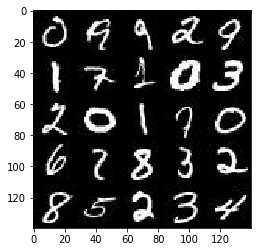

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

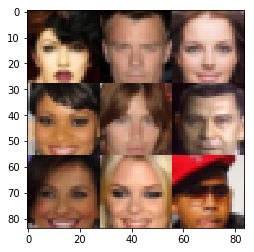

In [3]:
show_n_images = 10

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    z_inputs = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        # image: 28x28x[1|3]
        x = tf.layers.conv2d(images, 128, (5,5), (2,2), padding='same', activation=None)
        x = tf.maximum(0.2 * x, x)
        # 14x14x64 now
        
        x = tf.layers.conv2d(x, 256, (5,5), (2,2), padding='same', activation=None)
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(0.2 * x, x)
        # 7x7x128 now
        
        x = tf.layers.conv2d(x, 512, (5,5), (2,2), padding='valid', activation=None)
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(0.2 * x, x)
        # 2x2x512 now
        # print(x.shape)
        
        flat = tf.reshape(x, [-1, 4*4*512])
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits
#print([var.name for var in tf.trainable_variables()])
#tmp = discriminator(tf.zeros([1, 28, 28, 3], tf.float32), reuse=True)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        x = tf.layers.dense(z, 2*2*512, activation=None)
        
        x = tf.reshape(x, shape=[-1,2,2,512])
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        # 4x4x256 now
        #print("x: ", x.shape)
        
        conv1 = tf.layers.conv2d_transpose(
            x, 256, (5,5), (2,2), padding='valid', activation=None)
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        # 7x7x128 now
        #print("conv1: ", conv1.shape)
        
        conv2 = tf.layers.conv2d_transpose(
            conv1, 128, (5,5), (2,2), padding='same', activation=None)
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        # 14x14x64 now
        #print("conv2: ", conv2.shape)
        
        # Output layer, 28x28x3
        logits = tf.layers.conv2d_transpose(
            conv2, out_channel_dim, (5,5), (2,2), padding='same', activation=None)
        # 28x28x3 now
        #print("logits: ", logits.shape)
        
        out = tf.tanh(logits)
        
    return out
#tf.reset_default_graph()
#print("================")
#tmp = generator(tf.zeros([1, 100], tf.float32), 3)
#print("================")

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # <=== ??????
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
    print(data_shape)
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    losses = []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images*2
                steps += 1
                
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 100 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 300 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 4.0395... Generator Loss: 0.0335
Epoch 1/2... Discriminator Loss: 2.0030... Generator Loss: 12.0489
Epoch 1/2... Discriminator Loss: 1.3589... Generator Loss: 0.5687
Epoch 1/2... Discriminator Loss: 0.8262... Generator Loss: 6.1419
Epoch 1/2... Discriminator Loss: 1.4265... Generator Loss: 9.0862
Epoch 1/2... Discriminator Loss: 0.3676... Generator Loss: 5.0414
Epoch 1/2... Discriminator Loss: 0.5048... Generator Loss: 2.4100
Epoch 1/2... Discriminator Loss: 1.0018... Generator Loss: 0.8628
Epoch 1/2... Discriminator Loss: 0.5937... Generator Loss: 1.6452
Epoch 1/2... Discriminator Loss: 0.5929... Generator Loss: 1.6328


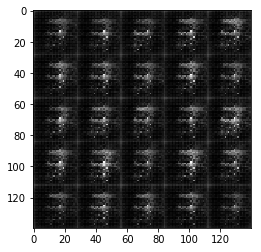

Epoch 1/2... Discriminator Loss: 1.0434... Generator Loss: 0.9405
Epoch 1/2... Discriminator Loss: 0.5396... Generator Loss: 2.2055
Epoch 1/2... Discriminator Loss: 0.4883... Generator Loss: 2.6417
Epoch 1/2... Discriminator Loss: 0.6669... Generator Loss: 1.6187
Epoch 1/2... Discriminator Loss: 0.8253... Generator Loss: 1.0490
Epoch 1/2... Discriminator Loss: 1.2213... Generator Loss: 0.7120
Epoch 1/2... Discriminator Loss: 0.6466... Generator Loss: 1.6974
Epoch 1/2... Discriminator Loss: 0.5292... Generator Loss: 2.1201
Epoch 1/2... Discriminator Loss: 0.6765... Generator Loss: 1.5620
Epoch 1/2... Discriminator Loss: 0.4289... Generator Loss: 4.7075


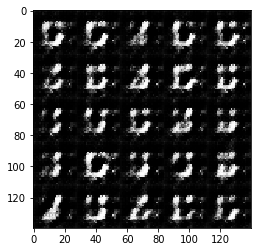

Epoch 1/2... Discriminator Loss: 0.5544... Generator Loss: 4.3063
Epoch 1/2... Discriminator Loss: 0.7518... Generator Loss: 1.4977
Epoch 1/2... Discriminator Loss: 0.5242... Generator Loss: 2.5222
Epoch 1/2... Discriminator Loss: 0.6553... Generator Loss: 1.5327
Epoch 1/2... Discriminator Loss: 0.4734... Generator Loss: 3.0611
Epoch 1/2... Discriminator Loss: 1.1680... Generator Loss: 0.7101
Epoch 1/2... Discriminator Loss: 0.7938... Generator Loss: 1.4761
Epoch 1/2... Discriminator Loss: 0.8670... Generator Loss: 5.4613
Epoch 1/2... Discriminator Loss: 0.7681... Generator Loss: 1.3709
Epoch 1/2... Discriminator Loss: 0.5915... Generator Loss: 1.9172


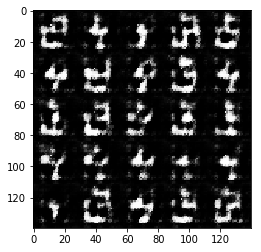

Epoch 1/2... Discriminator Loss: 0.7746... Generator Loss: 2.8999
Epoch 1/2... Discriminator Loss: 0.8846... Generator Loss: 1.0194
Epoch 1/2... Discriminator Loss: 0.7491... Generator Loss: 2.0631
Epoch 1/2... Discriminator Loss: 1.3558... Generator Loss: 0.6412
Epoch 1/2... Discriminator Loss: 0.6933... Generator Loss: 2.0026
Epoch 1/2... Discriminator Loss: 0.7393... Generator Loss: 2.2051
Epoch 1/2... Discriminator Loss: 0.6422... Generator Loss: 1.8711
Epoch 1/2... Discriminator Loss: 0.8394... Generator Loss: 1.1006
Epoch 1/2... Discriminator Loss: 0.6961... Generator Loss: 2.1662
Epoch 1/2... Discriminator Loss: 0.7013... Generator Loss: 1.5971


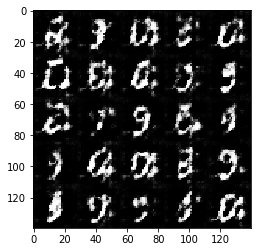

Epoch 1/2... Discriminator Loss: 0.6300... Generator Loss: 3.1572
Epoch 1/2... Discriminator Loss: 0.6059... Generator Loss: 2.9867
Epoch 1/2... Discriminator Loss: 0.9217... Generator Loss: 1.1179
Epoch 1/2... Discriminator Loss: 0.8034... Generator Loss: 1.3247
Epoch 1/2... Discriminator Loss: 1.3770... Generator Loss: 3.8795
Epoch 1/2... Discriminator Loss: 0.6714... Generator Loss: 1.9290
Epoch 1/2... Discriminator Loss: 0.8967... Generator Loss: 2.4952
Epoch 1/2... Discriminator Loss: 0.8020... Generator Loss: 1.3680
Epoch 1/2... Discriminator Loss: 0.8971... Generator Loss: 1.0366
Epoch 1/2... Discriminator Loss: 0.6941... Generator Loss: 1.5086


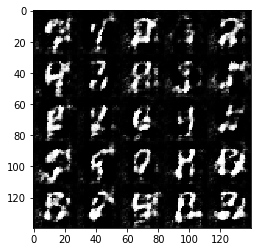

Epoch 1/2... Discriminator Loss: 0.6579... Generator Loss: 2.3943
Epoch 1/2... Discriminator Loss: 0.6059... Generator Loss: 2.6510
Epoch 1/2... Discriminator Loss: 0.8310... Generator Loss: 1.1248
Epoch 1/2... Discriminator Loss: 0.7022... Generator Loss: 2.5920
Epoch 1/2... Discriminator Loss: 0.6268... Generator Loss: 1.9494
Epoch 1/2... Discriminator Loss: 0.7543... Generator Loss: 1.5766
Epoch 1/2... Discriminator Loss: 0.6773... Generator Loss: 2.0224
Epoch 1/2... Discriminator Loss: 0.9196... Generator Loss: 1.1140
Epoch 1/2... Discriminator Loss: 1.0312... Generator Loss: 0.8328
Epoch 1/2... Discriminator Loss: 0.7769... Generator Loss: 1.2908


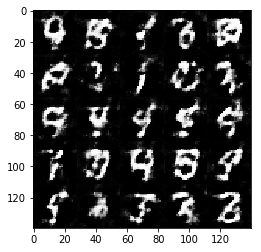

Epoch 1/2... Discriminator Loss: 0.6676... Generator Loss: 1.6523
Epoch 1/2... Discriminator Loss: 0.6458... Generator Loss: 2.0652
Epoch 1/2... Discriminator Loss: 0.8574... Generator Loss: 3.0834
Epoch 1/2... Discriminator Loss: 0.6135... Generator Loss: 1.7457
Epoch 1/2... Discriminator Loss: 0.8363... Generator Loss: 1.4726
Epoch 1/2... Discriminator Loss: 0.8983... Generator Loss: 1.0426
Epoch 1/2... Discriminator Loss: 0.9946... Generator Loss: 0.8667
Epoch 1/2... Discriminator Loss: 0.7923... Generator Loss: 1.2443
Epoch 1/2... Discriminator Loss: 0.8236... Generator Loss: 1.1979
Epoch 1/2... Discriminator Loss: 0.6985... Generator Loss: 2.7213


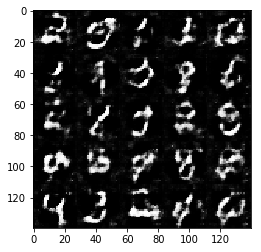

Epoch 1/2... Discriminator Loss: 0.6084... Generator Loss: 1.7177
Epoch 1/2... Discriminator Loss: 1.3064... Generator Loss: 3.6056
Epoch 1/2... Discriminator Loss: 0.6309... Generator Loss: 1.9419
Epoch 1/2... Discriminator Loss: 1.5898... Generator Loss: 0.4513
Epoch 1/2... Discriminator Loss: 0.7298... Generator Loss: 1.3390
Epoch 1/2... Discriminator Loss: 0.8964... Generator Loss: 1.0828
Epoch 1/2... Discriminator Loss: 0.6237... Generator Loss: 2.4901
Epoch 1/2... Discriminator Loss: 1.3650... Generator Loss: 0.5230
Epoch 1/2... Discriminator Loss: 0.7331... Generator Loss: 2.0614
Epoch 1/2... Discriminator Loss: 0.7138... Generator Loss: 1.4331


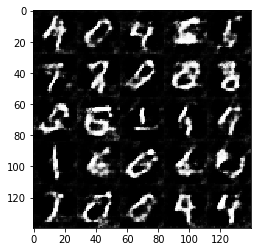

Epoch 1/2... Discriminator Loss: 1.0863... Generator Loss: 3.2771
Epoch 1/2... Discriminator Loss: 0.6174... Generator Loss: 2.5019
Epoch 1/2... Discriminator Loss: 1.2775... Generator Loss: 4.3826
Epoch 1/2... Discriminator Loss: 0.7591... Generator Loss: 1.2853
Epoch 1/2... Discriminator Loss: 0.9066... Generator Loss: 0.9002
Epoch 1/2... Discriminator Loss: 0.5851... Generator Loss: 1.7464
Epoch 1/2... Discriminator Loss: 0.9795... Generator Loss: 0.7804
Epoch 1/2... Discriminator Loss: 0.5888... Generator Loss: 2.1995
Epoch 1/2... Discriminator Loss: 1.1292... Generator Loss: 0.6615
Epoch 1/2... Discriminator Loss: 1.0994... Generator Loss: 0.7623


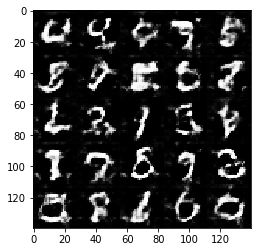

Epoch 1/2... Discriminator Loss: 0.7411... Generator Loss: 1.3674
Epoch 1/2... Discriminator Loss: 0.6827... Generator Loss: 2.0477
Epoch 1/2... Discriminator Loss: 0.6238... Generator Loss: 2.0547
Epoch 2/2... Discriminator Loss: 0.6591... Generator Loss: 2.2436
Epoch 2/2... Discriminator Loss: 0.6893... Generator Loss: 1.8515
Epoch 2/2... Discriminator Loss: 0.7203... Generator Loss: 2.3654
Epoch 2/2... Discriminator Loss: 1.1110... Generator Loss: 0.7658
Epoch 2/2... Discriminator Loss: 0.8030... Generator Loss: 2.0744
Epoch 2/2... Discriminator Loss: 0.9658... Generator Loss: 0.8767
Epoch 2/2... Discriminator Loss: 1.0295... Generator Loss: 0.8353


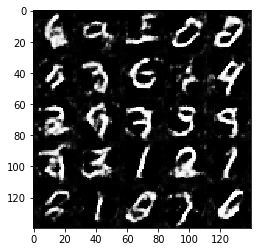

Epoch 2/2... Discriminator Loss: 1.1300... Generator Loss: 0.7458
Epoch 2/2... Discriminator Loss: 0.6916... Generator Loss: 1.5244
Epoch 2/2... Discriminator Loss: 0.7042... Generator Loss: 1.4046
Epoch 2/2... Discriminator Loss: 0.8094... Generator Loss: 2.2832
Epoch 2/2... Discriminator Loss: 0.7219... Generator Loss: 1.3048
Epoch 2/2... Discriminator Loss: 0.8797... Generator Loss: 2.9551
Epoch 2/2... Discriminator Loss: 0.6329... Generator Loss: 1.6661
Epoch 2/2... Discriminator Loss: 0.8152... Generator Loss: 1.0402
Epoch 2/2... Discriminator Loss: 0.7528... Generator Loss: 1.2105
Epoch 2/2... Discriminator Loss: 1.0258... Generator Loss: 0.8077


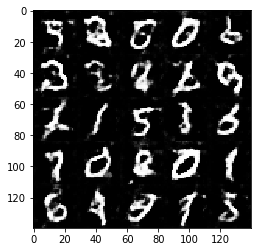

Epoch 2/2... Discriminator Loss: 0.6628... Generator Loss: 2.4257
Epoch 2/2... Discriminator Loss: 0.5896... Generator Loss: 2.2991
Epoch 2/2... Discriminator Loss: 0.8006... Generator Loss: 2.6065
Epoch 2/2... Discriminator Loss: 0.7653... Generator Loss: 1.2104
Epoch 2/2... Discriminator Loss: 0.7313... Generator Loss: 1.3748
Epoch 2/2... Discriminator Loss: 1.1512... Generator Loss: 0.7622
Epoch 2/2... Discriminator Loss: 0.8832... Generator Loss: 3.7309
Epoch 2/2... Discriminator Loss: 0.9453... Generator Loss: 1.4048
Epoch 2/2... Discriminator Loss: 0.6306... Generator Loss: 1.6980
Epoch 2/2... Discriminator Loss: 0.7267... Generator Loss: 1.3159


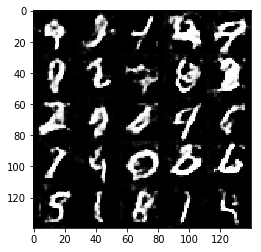

Epoch 2/2... Discriminator Loss: 0.6371... Generator Loss: 1.7556
Epoch 2/2... Discriminator Loss: 0.5445... Generator Loss: 2.2538
Epoch 2/2... Discriminator Loss: 0.9772... Generator Loss: 0.8796
Epoch 2/2... Discriminator Loss: 1.1596... Generator Loss: 0.6683
Epoch 2/2... Discriminator Loss: 2.8302... Generator Loss: 0.1471
Epoch 2/2... Discriminator Loss: 0.6919... Generator Loss: 1.6059
Epoch 2/2... Discriminator Loss: 0.6491... Generator Loss: 1.6432
Epoch 2/2... Discriminator Loss: 0.4752... Generator Loss: 2.3523
Epoch 2/2... Discriminator Loss: 0.5068... Generator Loss: 2.4942
Epoch 2/2... Discriminator Loss: 0.5481... Generator Loss: 2.0114


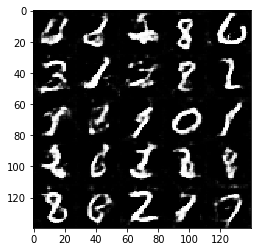

Epoch 2/2... Discriminator Loss: 0.6270... Generator Loss: 1.5587
Epoch 2/2... Discriminator Loss: 0.6556... Generator Loss: 1.5493
Epoch 2/2... Discriminator Loss: 0.6770... Generator Loss: 1.4801
Epoch 2/2... Discriminator Loss: 0.6294... Generator Loss: 1.6248
Epoch 2/2... Discriminator Loss: 0.5883... Generator Loss: 1.8386
Epoch 2/2... Discriminator Loss: 0.5560... Generator Loss: 1.8639
Epoch 2/2... Discriminator Loss: 1.0306... Generator Loss: 3.3140
Epoch 2/2... Discriminator Loss: 0.9122... Generator Loss: 1.2375
Epoch 2/2... Discriminator Loss: 0.9529... Generator Loss: 1.0358
Epoch 2/2... Discriminator Loss: 0.7198... Generator Loss: 2.7500


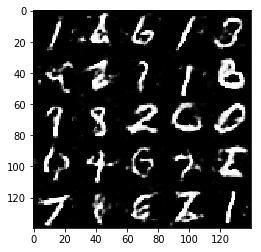

Epoch 2/2... Discriminator Loss: 0.8084... Generator Loss: 1.2590
Epoch 2/2... Discriminator Loss: 0.6711... Generator Loss: 2.2371
Epoch 2/2... Discriminator Loss: 0.9600... Generator Loss: 0.8645
Epoch 2/2... Discriminator Loss: 0.5987... Generator Loss: 1.8721
Epoch 2/2... Discriminator Loss: 0.6555... Generator Loss: 1.4409
Epoch 2/2... Discriminator Loss: 0.5744... Generator Loss: 2.1217
Epoch 2/2... Discriminator Loss: 0.5970... Generator Loss: 1.6357
Epoch 2/2... Discriminator Loss: 0.7036... Generator Loss: 1.5536
Epoch 2/2... Discriminator Loss: 0.7069... Generator Loss: 1.2930
Epoch 2/2... Discriminator Loss: 1.1658... Generator Loss: 0.6366


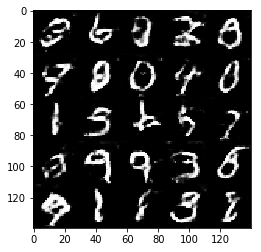

Epoch 2/2... Discriminator Loss: 1.6201... Generator Loss: 0.4323
Epoch 2/2... Discriminator Loss: 0.9786... Generator Loss: 0.8950
Epoch 2/2... Discriminator Loss: 0.6997... Generator Loss: 1.2671
Epoch 2/2... Discriminator Loss: 0.6385... Generator Loss: 1.5079
Epoch 2/2... Discriminator Loss: 0.9163... Generator Loss: 0.8926
Epoch 2/2... Discriminator Loss: 1.0551... Generator Loss: 3.3415
Epoch 2/2... Discriminator Loss: 0.7405... Generator Loss: 1.2003
Epoch 2/2... Discriminator Loss: 0.8610... Generator Loss: 0.9397
Epoch 2/2... Discriminator Loss: 0.7246... Generator Loss: 1.2958
Epoch 2/2... Discriminator Loss: 1.4894... Generator Loss: 3.4851


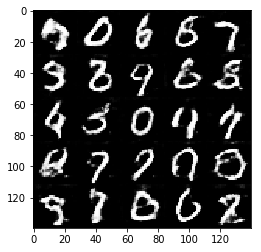

Epoch 2/2... Discriminator Loss: 0.8116... Generator Loss: 1.1577
Epoch 2/2... Discriminator Loss: 0.9187... Generator Loss: 1.9068
Epoch 2/2... Discriminator Loss: 0.6033... Generator Loss: 1.7332
Epoch 2/2... Discriminator Loss: 0.5671... Generator Loss: 1.6915
Epoch 2/2... Discriminator Loss: 0.5923... Generator Loss: 1.8855
Epoch 2/2... Discriminator Loss: 0.9405... Generator Loss: 2.9356
Epoch 2/2... Discriminator Loss: 1.2845... Generator Loss: 0.7576
Epoch 2/2... Discriminator Loss: 0.7021... Generator Loss: 1.4261
Epoch 2/2... Discriminator Loss: 0.5945... Generator Loss: 1.7788
Epoch 2/2... Discriminator Loss: 0.7622... Generator Loss: 1.1557


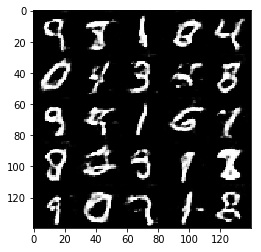

Epoch 2/2... Discriminator Loss: 1.4079... Generator Loss: 0.5497
Epoch 2/2... Discriminator Loss: 0.7838... Generator Loss: 1.2360
Epoch 2/2... Discriminator Loss: 0.7005... Generator Loss: 1.9540
Epoch 2/2... Discriminator Loss: 0.8311... Generator Loss: 1.0850
Epoch 2/2... Discriminator Loss: 0.7381... Generator Loss: 1.2827
Epoch 2/2... Discriminator Loss: 0.8277... Generator Loss: 1.0125
Epoch 2/2... Discriminator Loss: 1.5043... Generator Loss: 0.5151
Epoch 2/2... Discriminator Loss: 0.7028... Generator Loss: 1.4302
Epoch 2/2... Discriminator Loss: 0.6920... Generator Loss: 1.4986
Epoch 2/2... Discriminator Loss: 0.7304... Generator Loss: 1.3121


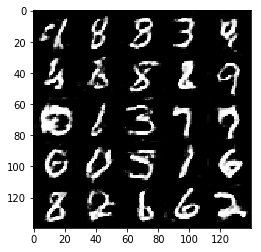

Epoch 2/2... Discriminator Loss: 1.0268... Generator Loss: 0.9637
Epoch 2/2... Discriminator Loss: 0.8998... Generator Loss: 0.9394
Epoch 2/2... Discriminator Loss: 0.5181... Generator Loss: 2.5634
Epoch 2/2... Discriminator Loss: 0.8904... Generator Loss: 0.9357
Epoch 2/2... Discriminator Loss: 0.6984... Generator Loss: 1.8697
Epoch 2/2... Discriminator Loss: 0.5867... Generator Loss: 1.8653
Epoch 2/2... Discriminator Loss: 0.7049... Generator Loss: 1.5008


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epoch 1/1... Discriminator Loss: 0.4781... Generator Loss: 7.2833
Epoch 1/1... Discriminator Loss: 0.4797... Generator Loss: 10.5610
Epoch 1/1... Discriminator Loss: 0.4026... Generator Loss: 5.3195
Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 13.4240
Epoch 1/1... Discriminator Loss: 0.4114... Generator Loss: 4.8442
Epoch 1/1... Discriminator Loss: 0.4859... Generator Loss: 4.2848
Epoch 1/1... Discriminator Loss: 0.4890... Generator Loss: 2.2544
Epoch 1/1... Discriminator Loss: 1.0123... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 0.5571... Generator Loss: 2.8355
Epoch 1/1... Discriminator Loss: 0.5271... Generator Loss: 2.1487


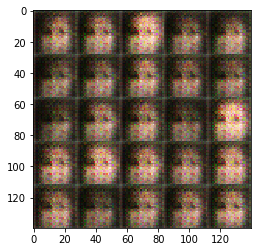

Epoch 1/1... Discriminator Loss: 0.4753... Generator Loss: 2.9326
Epoch 1/1... Discriminator Loss: 0.4634... Generator Loss: 3.1596
Epoch 1/1... Discriminator Loss: 0.6650... Generator Loss: 1.4724
Epoch 1/1... Discriminator Loss: 0.7462... Generator Loss: 1.2431
Epoch 1/1... Discriminator Loss: 0.4752... Generator Loss: 3.5394
Epoch 1/1... Discriminator Loss: 0.7729... Generator Loss: 1.2434
Epoch 1/1... Discriminator Loss: 0.5898... Generator Loss: 2.3798
Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 7.8253
Epoch 1/1... Discriminator Loss: 0.4952... Generator Loss: 3.7971
Epoch 1/1... Discriminator Loss: 0.8353... Generator Loss: 1.3880


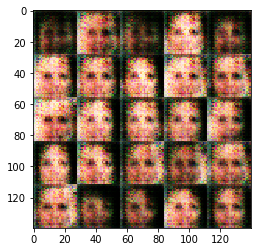

Epoch 1/1... Discriminator Loss: 0.7330... Generator Loss: 4.7468
Epoch 1/1... Discriminator Loss: 0.5516... Generator Loss: 2.9256
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.9844
Epoch 1/1... Discriminator Loss: 0.6948... Generator Loss: 2.8865
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 4.2503
Epoch 1/1... Discriminator Loss: 0.8625... Generator Loss: 1.2478
Epoch 1/1... Discriminator Loss: 0.5799... Generator Loss: 2.0139
Epoch 1/1... Discriminator Loss: 0.7277... Generator Loss: 1.6465
Epoch 1/1... Discriminator Loss: 0.5690... Generator Loss: 1.7501
Epoch 1/1... Discriminator Loss: 0.9156... Generator Loss: 3.7939


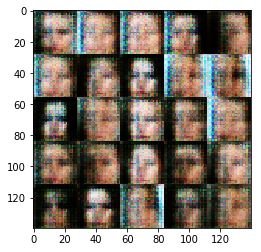

Epoch 1/1... Discriminator Loss: 0.5321... Generator Loss: 2.8709
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 0.7531... Generator Loss: 1.4373
Epoch 1/1... Discriminator Loss: 0.5879... Generator Loss: 2.2510
Epoch 1/1... Discriminator Loss: 0.4209... Generator Loss: 2.9542
Epoch 1/1... Discriminator Loss: 1.5481... Generator Loss: 0.5677
Epoch 1/1... Discriminator Loss: 1.0015... Generator Loss: 0.8594
Epoch 1/1... Discriminator Loss: 0.8701... Generator Loss: 1.1750
Epoch 1/1... Discriminator Loss: 0.8175... Generator Loss: 1.2998
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 0.7873


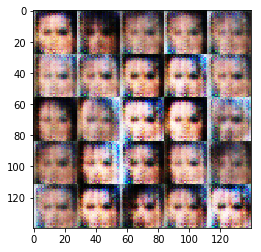

Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 0.7507... Generator Loss: 1.4280
Epoch 1/1... Discriminator Loss: 0.9576... Generator Loss: 2.2401
Epoch 1/1... Discriminator Loss: 0.8318... Generator Loss: 1.1609
Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 2.4657
Epoch 1/1... Discriminator Loss: 0.6000... Generator Loss: 2.8014
Epoch 1/1... Discriminator Loss: 0.5859... Generator Loss: 1.9387
Epoch 1/1... Discriminator Loss: 0.8566... Generator Loss: 1.1256
Epoch 1/1... Discriminator Loss: 0.7888... Generator Loss: 1.4177
Epoch 1/1... Discriminator Loss: 0.9797... Generator Loss: 0.8423


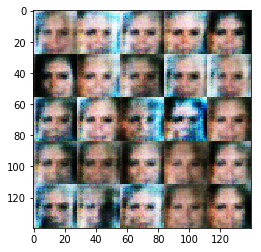

Epoch 1/1... Discriminator Loss: 0.7473... Generator Loss: 1.4737
Epoch 1/1... Discriminator Loss: 0.7288... Generator Loss: 1.4692
Epoch 1/1... Discriminator Loss: 0.7601... Generator Loss: 1.9164
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 2.9410
Epoch 1/1... Discriminator Loss: 0.8602... Generator Loss: 1.1469
Epoch 1/1... Discriminator Loss: 0.8081... Generator Loss: 1.3926
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.6054
Epoch 1/1... Discriminator Loss: 1.0615... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 0.6837... Generator Loss: 1.6647
Epoch 1/1... Discriminator Loss: 0.6944... Generator Loss: 1.4491


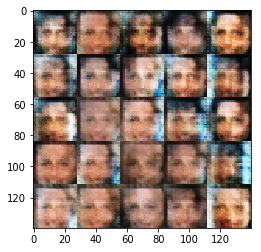

Epoch 1/1... Discriminator Loss: 0.7573... Generator Loss: 1.2465
Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 0.9340
Epoch 1/1... Discriminator Loss: 0.7744... Generator Loss: 1.9830
Epoch 1/1... Discriminator Loss: 0.9854... Generator Loss: 1.0984
Epoch 1/1... Discriminator Loss: 0.6907... Generator Loss: 1.6822
Epoch 1/1... Discriminator Loss: 0.8233... Generator Loss: 1.4860
Epoch 1/1... Discriminator Loss: 0.9032... Generator Loss: 1.1701
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 0.7164... Generator Loss: 1.5830
Epoch 1/1... Discriminator Loss: 0.8434... Generator Loss: 1.9295


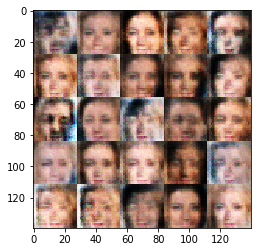

Epoch 1/1... Discriminator Loss: 0.9765... Generator Loss: 0.9843
Epoch 1/1... Discriminator Loss: 0.8636... Generator Loss: 1.1527
Epoch 1/1... Discriminator Loss: 0.9054... Generator Loss: 1.3572
Epoch 1/1... Discriminator Loss: 0.7301... Generator Loss: 2.0993
Epoch 1/1... Discriminator Loss: 0.9065... Generator Loss: 0.9204
Epoch 1/1... Discriminator Loss: 0.7783... Generator Loss: 1.6849
Epoch 1/1... Discriminator Loss: 0.8617... Generator Loss: 1.3347
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 3.6708
Epoch 1/1... Discriminator Loss: 0.7707... Generator Loss: 1.8977
Epoch 1/1... Discriminator Loss: 1.0328... Generator Loss: 0.9702


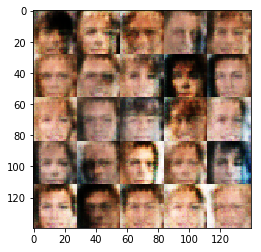

Epoch 1/1... Discriminator Loss: 0.8202... Generator Loss: 1.5414
Epoch 1/1... Discriminator Loss: 0.7435... Generator Loss: 1.4088
Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 0.9882... Generator Loss: 0.9086
Epoch 1/1... Discriminator Loss: 0.8569... Generator Loss: 1.2943
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 1.0255
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 0.7704... Generator Loss: 2.1619
Epoch 1/1... Discriminator Loss: 0.7617... Generator Loss: 1.7896
Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 0.7459


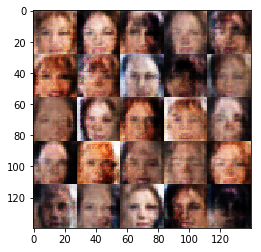

Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 2.7659
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.6211
Epoch 1/1... Discriminator Loss: 0.6959... Generator Loss: 1.6812
Epoch 1/1... Discriminator Loss: 0.9589... Generator Loss: 0.8828
Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 0.7735... Generator Loss: 1.4613
Epoch 1/1... Discriminator Loss: 0.9825... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 2.7094
Epoch 1/1... Discriminator Loss: 1.1772... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 0.9905... Generator Loss: 0.9449


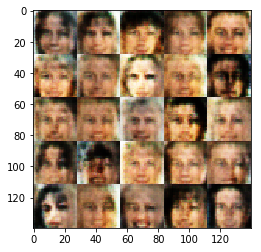

Epoch 1/1... Discriminator Loss: 0.8169... Generator Loss: 1.4414
Epoch 1/1... Discriminator Loss: 0.7696... Generator Loss: 1.7213
Epoch 1/1... Discriminator Loss: 0.8613... Generator Loss: 1.1091
Epoch 1/1... Discriminator Loss: 0.6370... Generator Loss: 2.6826
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.5291
Epoch 1/1... Discriminator Loss: 0.8627... Generator Loss: 1.2147
Epoch 1/1... Discriminator Loss: 0.8699... Generator Loss: 1.6536
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 0.7169... Generator Loss: 1.7949
Epoch 1/1... Discriminator Loss: 1.6324... Generator Loss: 0.3738


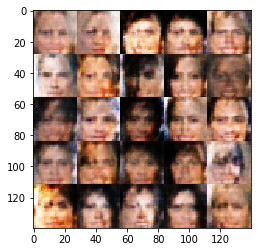

Epoch 1/1... Discriminator Loss: 1.0904... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 0.9193... Generator Loss: 1.0111
Epoch 1/1... Discriminator Loss: 0.8501... Generator Loss: 1.5368
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.0416... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.1335... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 0.6552... Generator Loss: 1.8294
Epoch 1/1... Discriminator Loss: 1.0683... Generator Loss: 3.1008
Epoch 1/1... Discriminator Loss: 0.7983... Generator Loss: 1.6927
Epoch 1/1... Discriminator Loss: 0.7505... Generator Loss: 1.3814


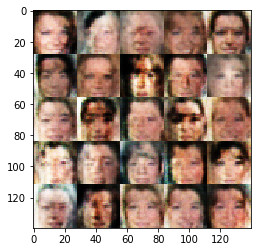

Epoch 1/1... Discriminator Loss: 0.9150... Generator Loss: 1.1525
Epoch 1/1... Discriminator Loss: 0.9324... Generator Loss: 1.0154
Epoch 1/1... Discriminator Loss: 0.7992... Generator Loss: 1.8109
Epoch 1/1... Discriminator Loss: 0.7300... Generator Loss: 1.5770
Epoch 1/1... Discriminator Loss: 0.6477... Generator Loss: 2.2945
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 0.6607... Generator Loss: 1.8396
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.4937
Epoch 1/1... Discriminator Loss: 0.7486... Generator Loss: 1.5621
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.5292


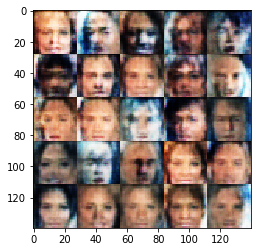

Epoch 1/1... Discriminator Loss: 0.6207... Generator Loss: 1.7896
Epoch 1/1... Discriminator Loss: 0.8042... Generator Loss: 1.2745
Epoch 1/1... Discriminator Loss: 0.7422... Generator Loss: 1.7441
Epoch 1/1... Discriminator Loss: 0.9607... Generator Loss: 1.0597
Epoch 1/1... Discriminator Loss: 0.9256... Generator Loss: 1.8003
Epoch 1/1... Discriminator Loss: 0.6857... Generator Loss: 1.5562
Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 2.7910
Epoch 1/1... Discriminator Loss: 0.7900... Generator Loss: 1.1154
Epoch 1/1... Discriminator Loss: 0.8673... Generator Loss: 1.0885
Epoch 1/1... Discriminator Loss: 0.6624... Generator Loss: 1.8461


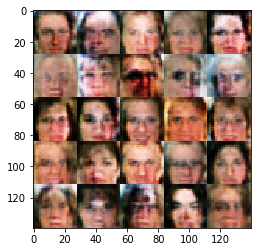

Epoch 1/1... Discriminator Loss: 0.8217... Generator Loss: 1.3855
Epoch 1/1... Discriminator Loss: 0.6473... Generator Loss: 1.7343
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 0.8194... Generator Loss: 1.2173
Epoch 1/1... Discriminator Loss: 0.8865... Generator Loss: 2.5745
Epoch 1/1... Discriminator Loss: 0.7939... Generator Loss: 1.2378
Epoch 1/1... Discriminator Loss: 0.6935... Generator Loss: 1.7072
Epoch 1/1... Discriminator Loss: 0.7607... Generator Loss: 1.3206
Epoch 1/1... Discriminator Loss: 0.7422... Generator Loss: 1.7911
Epoch 1/1... Discriminator Loss: 0.9040... Generator Loss: 0.9565


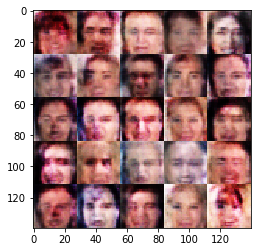

Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 3.4415
Epoch 1/1... Discriminator Loss: 0.6827... Generator Loss: 1.8808
Epoch 1/1... Discriminator Loss: 0.7851... Generator Loss: 1.4246
Epoch 1/1... Discriminator Loss: 0.9926... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.1098... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 0.9130... Generator Loss: 1.0165
Epoch 1/1... Discriminator Loss: 0.6909... Generator Loss: 1.5378
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.5142
Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 0.6505... Generator Loss: 2.1066


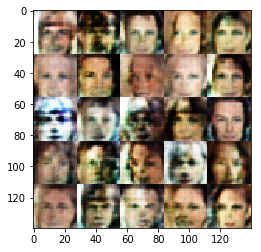

Epoch 1/1... Discriminator Loss: 0.8744... Generator Loss: 1.0051
Epoch 1/1... Discriminator Loss: 0.7079... Generator Loss: 1.5770
Epoch 1/1... Discriminator Loss: 0.7834... Generator Loss: 1.7416
Epoch 1/1... Discriminator Loss: 0.7156... Generator Loss: 1.7991
Epoch 1/1... Discriminator Loss: 1.6606... Generator Loss: 0.3671
Epoch 1/1... Discriminator Loss: 0.8354... Generator Loss: 1.3005
Epoch 1/1... Discriminator Loss: 0.8833... Generator Loss: 1.0243
Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 1.1090
Epoch 1/1... Discriminator Loss: 0.9116... Generator Loss: 1.0167
Epoch 1/1... Discriminator Loss: 0.8436... Generator Loss: 1.0634


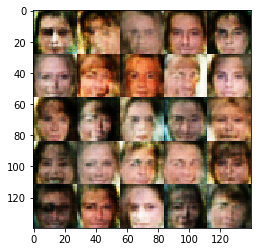

Epoch 1/1... Discriminator Loss: 0.9268... Generator Loss: 2.8439
Epoch 1/1... Discriminator Loss: 0.8619... Generator Loss: 1.2255
Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 0.9985
Epoch 1/1... Discriminator Loss: 0.6827... Generator Loss: 2.2495
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 0.8682
Epoch 1/1... Discriminator Loss: 1.5609... Generator Loss: 0.3958
Epoch 1/1... Discriminator Loss: 1.0742... Generator Loss: 2.8676
Epoch 1/1... Discriminator Loss: 0.9593... Generator Loss: 1.1021
Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 0.9278
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.6112


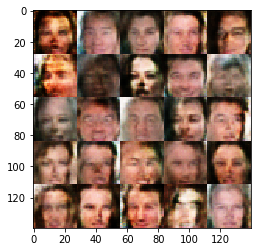

Epoch 1/1... Discriminator Loss: 0.9792... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 0.6672... Generator Loss: 1.7990
Epoch 1/1... Discriminator Loss: 0.8196... Generator Loss: 1.1139
Epoch 1/1... Discriminator Loss: 0.8628... Generator Loss: 1.0390
Epoch 1/1... Discriminator Loss: 0.7015... Generator Loss: 1.3119
Epoch 1/1... Discriminator Loss: 0.7386... Generator Loss: 1.4974
Epoch 1/1... Discriminator Loss: 0.6867... Generator Loss: 2.1621
Epoch 1/1... Discriminator Loss: 0.6706... Generator Loss: 1.7219
Epoch 1/1... Discriminator Loss: 0.7037... Generator Loss: 1.9299
Epoch 1/1... Discriminator Loss: 0.6818... Generator Loss: 2.5700


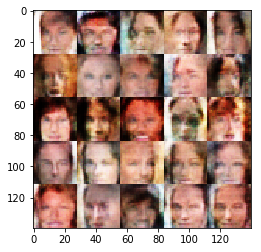

Epoch 1/1... Discriminator Loss: 0.6635... Generator Loss: 2.3864
Epoch 1/1... Discriminator Loss: 0.7222... Generator Loss: 1.6067
Epoch 1/1... Discriminator Loss: 0.7784... Generator Loss: 1.2890
Epoch 1/1... Discriminator Loss: 0.6558... Generator Loss: 2.0626
Epoch 1/1... Discriminator Loss: 0.8353... Generator Loss: 1.1460
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 0.9918
Epoch 1/1... Discriminator Loss: 1.0408... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 0.7134... Generator Loss: 1.5091
Epoch 1/1... Discriminator Loss: 1.0913... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 0.7530... Generator Loss: 1.4194


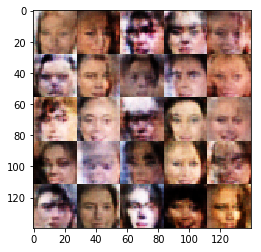

Epoch 1/1... Discriminator Loss: 0.7198... Generator Loss: 1.3567
Epoch 1/1... Discriminator Loss: 0.7591... Generator Loss: 1.3145
Epoch 1/1... Discriminator Loss: 0.9280... Generator Loss: 0.8765
Epoch 1/1... Discriminator Loss: 0.7910... Generator Loss: 1.1564
Epoch 1/1... Discriminator Loss: 1.0363... Generator Loss: 3.3528
Epoch 1/1... Discriminator Loss: 0.6358... Generator Loss: 2.0788
Epoch 1/1... Discriminator Loss: 0.9609... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 0.9073... Generator Loss: 1.0182
Epoch 1/1... Discriminator Loss: 0.6905... Generator Loss: 2.0661
Epoch 1/1... Discriminator Loss: 0.8280... Generator Loss: 1.2062


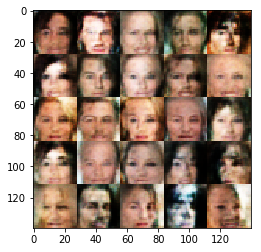

Epoch 1/1... Discriminator Loss: 0.8177... Generator Loss: 1.1578
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 0.6270... Generator Loss: 1.6285
Epoch 1/1... Discriminator Loss: 0.9014... Generator Loss: 1.1315
Epoch 1/1... Discriminator Loss: 0.9145... Generator Loss: 0.9881
Epoch 1/1... Discriminator Loss: 0.8083... Generator Loss: 1.1356
Epoch 1/1... Discriminator Loss: 0.6285... Generator Loss: 2.2823
Epoch 1/1... Discriminator Loss: 0.8079... Generator Loss: 1.4529
Epoch 1/1... Discriminator Loss: 0.8205... Generator Loss: 1.6577
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 5.3792


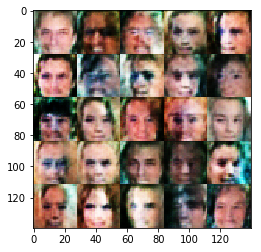

Epoch 1/1... Discriminator Loss: 1.0922... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 0.6191... Generator Loss: 1.9754
Epoch 1/1... Discriminator Loss: 1.0517... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.1162
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 3.2638
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 0.7764... Generator Loss: 1.2965
Epoch 1/1... Discriminator Loss: 0.7344... Generator Loss: 1.4281
Epoch 1/1... Discriminator Loss: 0.7611... Generator Loss: 1.3477
Epoch 1/1... Discriminator Loss: 0.7833... Generator Loss: 1.2246


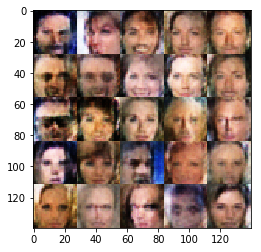

Epoch 1/1... Discriminator Loss: 0.9350... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 0.9637... Generator Loss: 1.0110
Epoch 1/1... Discriminator Loss: 0.7188... Generator Loss: 1.7392
Epoch 1/1... Discriminator Loss: 0.9500... Generator Loss: 0.9459
Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 1.0159
Epoch 1/1... Discriminator Loss: 0.7691... Generator Loss: 1.1831
Epoch 1/1... Discriminator Loss: 0.8039... Generator Loss: 1.1542
Epoch 1/1... Discriminator Loss: 0.8220... Generator Loss: 1.2490


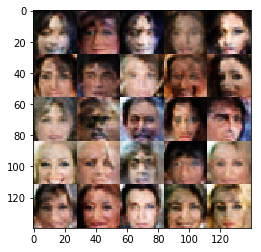

Epoch 1/1... Discriminator Loss: 0.9798... Generator Loss: 2.6107
Epoch 1/1... Discriminator Loss: 0.7620... Generator Loss: 1.9892
Epoch 1/1... Discriminator Loss: 0.9148... Generator Loss: 1.0489
Epoch 1/1... Discriminator Loss: 0.7715... Generator Loss: 1.2975
Epoch 1/1... Discriminator Loss: 0.8699... Generator Loss: 0.9657
Epoch 1/1... Discriminator Loss: 0.7980... Generator Loss: 1.3044
Epoch 1/1... Discriminator Loss: 0.9173... Generator Loss: 1.8412
Epoch 1/1... Discriminator Loss: 0.8864... Generator Loss: 0.9454
Epoch 1/1... Discriminator Loss: 0.8162... Generator Loss: 1.0676
Epoch 1/1... Discriminator Loss: 0.6285... Generator Loss: 1.7970


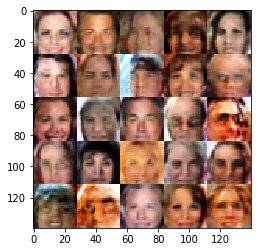

Epoch 1/1... Discriminator Loss: 0.6848... Generator Loss: 1.8898
Epoch 1/1... Discriminator Loss: 0.7015... Generator Loss: 1.8266
Epoch 1/1... Discriminator Loss: 0.6716... Generator Loss: 1.6713
Epoch 1/1... Discriminator Loss: 0.7443... Generator Loss: 1.7387
Epoch 1/1... Discriminator Loss: 0.8232... Generator Loss: 3.2943
Epoch 1/1... Discriminator Loss: 0.7724... Generator Loss: 2.5983
Epoch 1/1... Discriminator Loss: 0.6229... Generator Loss: 1.8956
Epoch 1/1... Discriminator Loss: 0.7081... Generator Loss: 1.6511
Epoch 1/1... Discriminator Loss: 0.8818... Generator Loss: 0.9676
Epoch 1/1... Discriminator Loss: 0.7302... Generator Loss: 2.3008


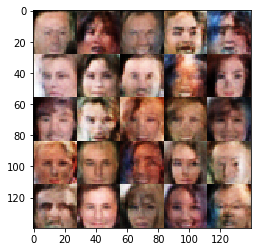

Epoch 1/1... Discriminator Loss: 1.0134... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 0.8893... Generator Loss: 1.1010
Epoch 1/1... Discriminator Loss: 0.7799... Generator Loss: 1.3301
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.5660
Epoch 1/1... Discriminator Loss: 0.6615... Generator Loss: 1.4532
Epoch 1/1... Discriminator Loss: 0.7280... Generator Loss: 1.3381
Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 0.8225
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.5567
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.6580


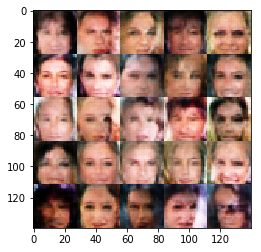

Epoch 1/1... Discriminator Loss: 0.7417... Generator Loss: 1.3195
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 3.6482
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 0.7703... Generator Loss: 1.4312
Epoch 1/1... Discriminator Loss: 1.0174... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 0.8040... Generator Loss: 2.7237
Epoch 1/1... Discriminator Loss: 0.8372... Generator Loss: 1.0448
Epoch 1/1... Discriminator Loss: 0.6935... Generator Loss: 1.5358
Epoch 1/1... Discriminator Loss: 0.6945... Generator Loss: 1.6166


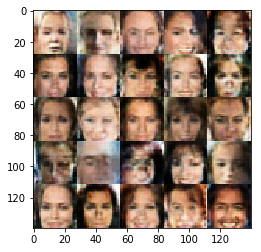

Epoch 1/1... Discriminator Loss: 0.8435... Generator Loss: 1.0516
Epoch 1/1... Discriminator Loss: 0.8224... Generator Loss: 1.1390
Epoch 1/1... Discriminator Loss: 0.9407... Generator Loss: 2.8527
Epoch 1/1... Discriminator Loss: 0.7488... Generator Loss: 1.7696
Epoch 1/1... Discriminator Loss: 0.5941... Generator Loss: 2.2664
Epoch 1/1... Discriminator Loss: 0.6642... Generator Loss: 1.9202
Epoch 1/1... Discriminator Loss: 1.0357... Generator Loss: 3.6285
Epoch 1/1... Discriminator Loss: 0.6560... Generator Loss: 1.7895
Epoch 1/1... Discriminator Loss: 0.5887... Generator Loss: 1.7700
Epoch 1/1... Discriminator Loss: 0.9596... Generator Loss: 0.9527


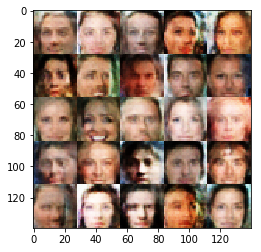

Epoch 1/1... Discriminator Loss: 0.7195... Generator Loss: 1.3583
Epoch 1/1... Discriminator Loss: 0.8566... Generator Loss: 1.7094
Epoch 1/1... Discriminator Loss: 0.8133... Generator Loss: 1.0343
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 0.7078... Generator Loss: 1.6954
Epoch 1/1... Discriminator Loss: 0.7277... Generator Loss: 1.6913
Epoch 1/1... Discriminator Loss: 0.9241... Generator Loss: 3.2241
Epoch 1/1... Discriminator Loss: 0.8692... Generator Loss: 0.9810
Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 1.5532
Epoch 1/1... Discriminator Loss: 0.7387... Generator Loss: 1.2416


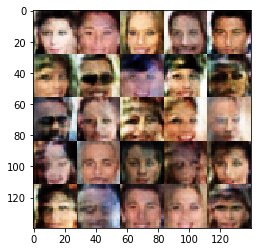

Epoch 1/1... Discriminator Loss: 0.9390... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 0.7069... Generator Loss: 1.3527
Epoch 1/1... Discriminator Loss: 0.6722... Generator Loss: 1.7309
Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 0.6648... Generator Loss: 1.5556
Epoch 1/1... Discriminator Loss: 0.6306... Generator Loss: 2.4228
Epoch 1/1... Discriminator Loss: 0.8701... Generator Loss: 1.0304
Epoch 1/1... Discriminator Loss: 0.7007... Generator Loss: 1.3608
Epoch 1/1... Discriminator Loss: 1.7213... Generator Loss: 0.3494
Epoch 1/1... Discriminator Loss: 0.6098... Generator Loss: 2.6761


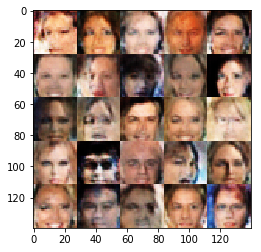

Epoch 1/1... Discriminator Loss: 0.8075... Generator Loss: 1.3113
Epoch 1/1... Discriminator Loss: 0.6640... Generator Loss: 1.9769
Epoch 1/1... Discriminator Loss: 0.9534... Generator Loss: 1.0358
Epoch 1/1... Discriminator Loss: 0.9157... Generator Loss: 1.0359
Epoch 1/1... Discriminator Loss: 0.7984... Generator Loss: 1.7124
Epoch 1/1... Discriminator Loss: 0.7851... Generator Loss: 1.1678


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.